In [26]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
# import geopandas as gpd
import json
from concurrent.futures import ThreadPoolExecutor
import os

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import networkx as nx
from cdlib import algorithms, evaluation


# Consistent theme
import plotly.io as pio
pio.templates.default = "plotly_white"

In [27]:
df = pd.read_csv("../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
df.head()

,patientId,sampleId,CLL_EPITYPE,DISEASE_TYPE,IGLV3_21_R110,MUTATION_COUNT,TMB_NONSYNONYMOUS,TUMOR_MOLECULAR_SUBTYPE,U1_STATUS,AGE,...,OS_MONTHS,OS_STATUS,PRIOR_TREATMENT_CATEGORY,SEX,TREATMENT_AFTER_SAMPLING,TREATMENT_STATUS,originId,year,originType,originIdentifier
0,P-CRC-0001,CRC-0001,n-CLL,CLL,No,26.0,0.866667,U-CLL,WT,44.0,...,147.19,1:DECEASED,Untreated,Female,Chemo + Ab,Pre-treatment,2,2019,PUBLICATION,PMID:31142838
1,P-CRC-0002,CRC-0002,n-CLL,CLL,No,23.0,0.766667,U-CLL,WT,55.0,...,154.49,1:DECEASED,Untreated,Male,Chemo + Ab,Pre-treatment,2,2019,PUBLICATION,PMID:31142838
2,P-CRC-0003,CRC-0003,n-CLL,CLL,No,7.0,0.233333,U-CLL,WT,63.0,...,51.25,1:DECEASED,Untreated,Female,Chemo + Ab,Pre-treatment,2,2019,PUBLICATION,PMID:31142838
3,P-CRC-0004,CRC-0004,m-CLL,CLL,No,30.0,1.000000,M-CLL,WT,51.0,...,183.55,0:LIVING,Untreated,Male,Chemo + Ab,Pre-treatment,2,2019,PUBLICATION,PMID:31142838
4,P-CRC-0005,CRC-0005,n-CLL,CLL,No,23.0,0.766667,U-CLL,WT,36.0,...,164.35,0:LIVING,Untreated,Male,Chemo + Ab,Pre-treatment,2,2019,PUBLICATION,PMID:31142838


In [28]:
PATH = "../triplet-community-detection/data/"
node_id_df = pd.read_csv(PATH + "node_mapping_with_id.csv")
display(node_id_df.head())

,node_name,node_id
0,*1019Lext*40,0
1,*143Wext*9,1
2,*186Wext*19,2
3,*1973Yext*?,3
4,*2001Kext*50,4


In [29]:
patientNodes = node_id_df[node_id_df['node_name'].str.startswith('Patient_')]['node_id'].tolist()
print(f"Number of patient nodes: {len(patientNodes)}")

Number of patient nodes: 1144


In [30]:
ALGO = "leiden-hierarchical/"
# ALGO = "leiden/"
# ALGO = "louvain/"
# ALGO = "asyn_lpa/"
community_df = pd.read_csv(PATH + ALGO + "community_mapping.csv")
community_df.head()

,node_id,community_id,level
0,116203,0,0
1,44895,0,0
2,44932,0,0
3,44947,0,0
4,45130,0,0


In [31]:
# add node_id to df, using patientId in df and "Patient_{patientId}" in node_to_id
df_with_id = df.copy(deep=True)
df_with_id['Patient'] = df_with_id['patientId'].apply(lambda x: f"Patient_{x}")
df_with_id = df_with_id.merge(node_id_df, left_on='Patient', right_on='node_name', how='left')
df_with_id = df_with_id.rename(columns={'node_id': 'patientNodeId'})
df_with_id = df_with_id.drop(columns=['node_name', 'Patient'])
print(df_with_id.columns)
df_with_id[['patientId', 'patientNodeId']].head()


Index(['patientId', 'sampleId', 'CLL_EPITYPE', 'DISEASE_TYPE', 'IGLV3_21_R110',
       'MUTATION_COUNT', 'TMB_NONSYNONYMOUS', 'TUMOR_MOLECULAR_SUBTYPE',
       'U1_STATUS', 'AGE', 'AGE_SAMPLING', 'COHORT', 'DEATH_DAYS',
       'EXPRESSION_CLUSTER', 'FFS_MONTHS', 'FFS_STATUS',
       'IGHV_IDENTITY_PERCENTAGE', 'IGHV_MUTATION_STATUS', 'OS_MONTHS',
       'OS_STATUS', 'PRIOR_TREATMENT_CATEGORY', 'SEX',
       'TREATMENT_AFTER_SAMPLING', 'TREATMENT_STATUS', 'originId', 'year',
       'originType', 'originIdentifier', 'patientNodeId'],
      dtype='object')


,patientId,patientNodeId
0,P-CRC-0001,44894
1,P-CRC-0002,44895
2,P-CRC-0003,44896
3,P-CRC-0004,44897
4,P-CRC-0005,44898


In [32]:
# for communities in level 1, filter community_df to level 0, then merge with df_with_id on patientNodeId and node_id
def get_community_df(df_with_id, community_df):
    df_with_id = df_with_id.merge(community_df, left_on='patientNodeId', right_on='node_id', how='left')
    return df_with_id


df_with_community = get_community_df(df_with_id, community_df)
print(df_with_community.columns) 

Index(['patientId', 'sampleId', 'CLL_EPITYPE', 'DISEASE_TYPE', 'IGLV3_21_R110',
       'MUTATION_COUNT', 'TMB_NONSYNONYMOUS', 'TUMOR_MOLECULAR_SUBTYPE',
       'U1_STATUS', 'AGE', 'AGE_SAMPLING', 'COHORT', 'DEATH_DAYS',
       'EXPRESSION_CLUSTER', 'FFS_MONTHS', 'FFS_STATUS',
       'IGHV_IDENTITY_PERCENTAGE', 'IGHV_MUTATION_STATUS', 'OS_MONTHS',
       'OS_STATUS', 'PRIOR_TREATMENT_CATEGORY', 'SEX',
       'TREATMENT_AFTER_SAMPLING', 'TREATMENT_STATUS', 'originId', 'year',
       'originType', 'originIdentifier', 'patientNodeId', 'node_id',
       'community_id', 'level'],
      dtype='object')


In [33]:
df_with_community[df_with_community['level'].notnull()][['patientId', 'patientNodeId', 'community_id', 'level']]

,patientId,patientNodeId,community_id,level
0,P-CRC-0001,44894,17,0
1,P-CRC-0001,44894,264,1
2,P-CRC-0002,44895,0,0
3,P-CRC-0002,44895,109,1
4,P-CRC-0003,44896,24,0
...,...,...,...,...
2607,P-SCLL-0504,46035,779,1
2608,P-SCLL-0505,46036,8,0
2609,P-SCLL-0505,46036,187,1
2610,P-SCLL-0506,46037,13,0


In [34]:
df_with_community[df_with_community['level'] == 0][['patientId', 'patientNodeId', 'community_id', 'level']]

,patientId,patientNodeId,community_id,level
0,P-CRC-0001,44894,17,0
2,P-CRC-0002,44895,0,0
4,P-CRC-0003,44896,24,0
7,P-CRC-0004,44897,22,0
9,P-CRC-0005,44898,77,0
...,...,...,...,...
2602,P-SCLL-0502,46033,24,0
2604,P-SCLL-0503,46034,67,0
2606,P-SCLL-0504,46035,68,0
2608,P-SCLL-0505,46036,8,0


In [35]:
df_with_community[df_with_community['level'] == 2]['community_id'].nunique()

45

In [36]:
def evaluate_ground_truth(df_with_community, level=1, col='CLL_EPITYPE'):
    """
    Evaluate the community detection results against a ground truth label.
    
    Parameters:
    - df_with_community: DataFrame containing community detection results and ground truth labels.
    - level: The level of community detection to evaluate.
    - col: The column name of the ground truth labels.
    
    Returns:
    - None, but prints NMI and ARI scores.
    """

    subset = df_with_community[(df_with_community['level'] == level) & (df_with_community[col].notnull())]

    true_labels = subset[col] 
    pred_labels = subset['community_id']

    print(f"Evaluating at level {level} with ground truth column '{col}':")
    print("NMI:", normalized_mutual_info_score(true_labels, pred_labels))
    print("ARI:", adjusted_rand_score(true_labels, pred_labels))


evaluate_ground_truth(df_with_community, level=0, col='CLL_EPITYPE')
evaluate_ground_truth(df_with_community, level=0, col='TUMOR_MOLECULAR_SUBTYPE')
# evaluate_ground_truth(df_with_community, level=1, col='CLL_EPITYPE')
# evaluate_ground_truth(df_with_community, level=1, col='TUMOR_MOLECULAR_SUBTYPE')


Evaluating at level 0 with ground truth column 'CLL_EPITYPE':
NMI: 0.09161515901458585
ARI: 0.031452325127180734
Evaluating at level 0 with ground truth column 'TUMOR_MOLECULAR_SUBTYPE':
NMI: 0.02651057411633924
ARI: 0.00031225107921070754


Plotting proportions for CLL_EPITYPE


Plotting proportions for SEX


Plotting proportions for TUMOR_MOLECULAR_SUBTYPE


Plotting proportions for AGE_SAMPLING


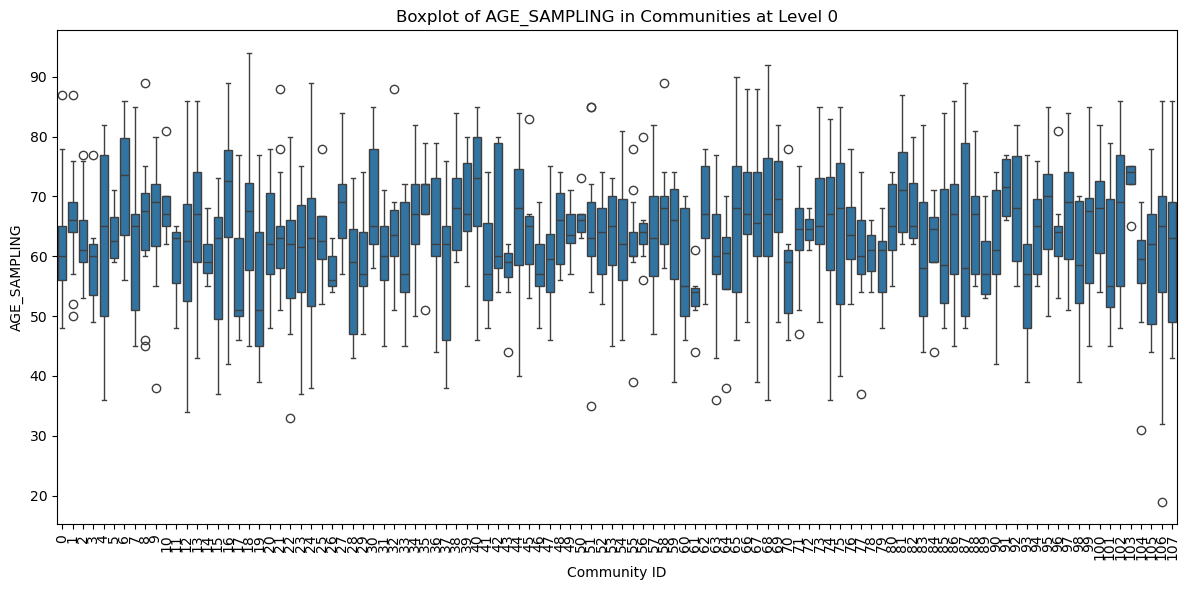

Plotting proportions for TREATMENT_STATUS


Plotting proportions for PRIOR_TREATMENT_CATEGORY


Plotting proportions for TREATMENT_AFTER_SAMPLING


In [37]:
# provide column proportions for each community and plot them
def plot_community_proportions(df, level, column):
    # Filter for the specified level
    df_level = df[df['level'] == level]

    # If cateogircal
    if df_level[column].dtype == 'object' or df_level[column].dtype.name == 'category':
        # Group by community and calculate proportions
        proportions = df_level.groupby(['community_id', column]).size().unstack(fill_value=0)
        proportions = proportions.div(proportions.sum(axis=1), axis=0)  # Normalize to get proportions
        # Reset index for plotting
        proportions = proportions.reset_index()
        proportions = proportions.melt(id_vars='community_id', var_name=column, value_name='proportion')
        # Plot using Plotly
        fig = px.bar(proportions, x='community_id', y='proportion', color=column, barmode='stack',
                    title=f'Proportions of {column} in Communities at Level {level}')
        fig.update_layout(xaxis_title='Community ID', yaxis_title='Proportion')
        fig.show()
    
    # If numerical, do a box plot
    elif np.issubdtype(df_level[column].dtype, np.number):
        # Plot using Seaborn
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='community_id', y=column, data=df_level)
        plt.title(f'Boxplot of {column} in Communities at Level {level}')
        plt.xlabel('Community ID')
        plt.ylabel(column)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column {column} is neither categorical nor numerical.")

checking_cols =['CLL_EPITYPE', 'SEX', 'TUMOR_MOLECULAR_SUBTYPE', 'AGE_SAMPLING', 'TREATMENT_STATUS', 'PRIOR_TREATMENT_CATEGORY', 'TREATMENT_AFTER_SAMPLING']
# Plot proportions
for col in checking_cols:
        print(f"Plotting proportions for {col}")
        plot_community_proportions(df_with_community, level=0, column=col)


In [38]:
mutation_df = pd.read_csv('../data/thesis/cll_broad_2022_mutations_thesis.csv')

In [39]:
def plot_top5_genes_per_community_plotly(df_with_community, mutation_df, level=0):
    # Merge mutation data with community assignments
    merged = mutation_df.merge(
        df_with_community[df_with_community['level'] == level][['patientId', 'community_id']],
        on='patientId', how='inner'
    )

    # Count gene occurrences per community
    gene_counts = merged.groupby(['community_id', 'hugoGeneSymbol'])['patientId'].nunique().reset_index(name='count')

    # Total patients per community
    total_patients_per_community = df_with_community[df_with_community['level'] == level].groupby('community_id')['patientId'].nunique()

    # Calculate proportion for each gene in each community
    gene_counts['proportion'] = gene_counts.apply(
        lambda row: row['count'] / total_patients_per_community.loc[row['community_id']], axis=1
    )

    # For each community, get top 5 genes by proportion
    top_genes_per_community = gene_counts.groupby('community_id').apply(
        lambda x: x.nlargest(5, 'proportion')
    ).reset_index(drop=True)

    # Prepare data for Plotly: each gene-community pair is a bar segment
    communities = sorted(top_genes_per_community['community_id'].unique())
    fig = go.Figure()
    for community in communities:
        comm_df = top_genes_per_community[top_genes_per_community['community_id'] == community]
        # Sort by proportion for nice stacking
        comm_df = comm_df.sort_values('proportion', ascending=False)
        fig.add_trace(go.Bar(
            x=[str(community)]*len(comm_df),
            y=comm_df['proportion'],
            name=f"Community {community}",
            text=comm_df['hugoGeneSymbol'],
            customdata=comm_df['hugoGeneSymbol'],
            hovertemplate='Community: %{x}<br>Gene: %{customdata}<br>Proportion: %{y:.2f}<extra></extra>',
            marker=dict(line=dict(width=0.5, color='black'))
        ))

    # Now stack by gene, not by community, so we need to plot each gene as a trace
    # Instead, let's pivot so each gene is a trace, and missing genes are zero
    pivot = top_genes_per_community.pivot(index='community_id', columns='hugoGeneSymbol', values='proportion').fillna(0)
    # Only keep genes that are in the top 5 for any community
    top_genes = top_genes_per_community['hugoGeneSymbol'].unique()
    for gene in top_genes:
        fig.add_trace(go.Bar(
            x=pivot.index.astype(str),
            y=pivot[gene] if gene in pivot.columns else [0]*len(pivot),
            name=gene,
            hovertemplate='Community: %{x}<br>Gene: '+gene+'<br>Proportion: %{y:.2f}<extra></extra>',
        ))

    fig.update_layout(
        barmode='stack',
        title=f"Top 5 Genes by Proportion in Each Community (Level {level})",
        xaxis_title="Community ID",
        yaxis_title="Proportion of Patients with Mutation",
        legend_title="Gene",
        width=900,
        height=500
    )
    fig.show()

# Usage:
plot_top5_genes_per_community_plotly(df_with_community, mutation_df, level=0)

In [40]:
# make graph of  number of patients per community
def plot_patients_per_community(df_with_community, level=0):
    # Count number of patients in each community at the specified level
    patient_counts = df_with_community[df_with_community['level'] == level].groupby('community_id')['patientId'].nunique().reset_index()
    patient_counts = patient_counts.rename(columns={'patientId': 'num_patients'})

    # Create a bar plot using Plotly
    fig = px.bar(patient_counts, x='community_id', y='num_patients',
                 title=f'Number of Patients per Community at Level {level}',
                 labels={'community_id': 'Community ID', 'num_patients': 'Number of Patients'},
                 color='num_patients', color_continuous_scale='Viridis')

    fig.update_layout(xaxis_title='Community ID', yaxis_title='Number of Patients')
    fig.show()


# Usage:
plot_patients_per_community(df_with_community, level=0)